In [1]:
import pandas as pd
from copy import deepcopy
import os
from joblib import Parallel, delayed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
from glob import glob

In [3]:
import pwlf

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
def canbefloat(x):
    try:
        float(x)
    except:
        return False
    else:
        return True
ucanbefloat = lambda t: canbefloat(t)
vfunc = np.vectorize(ucanbefloat)

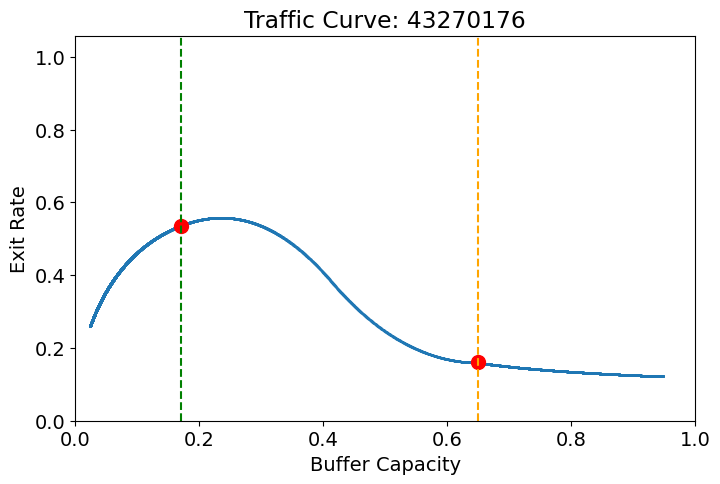

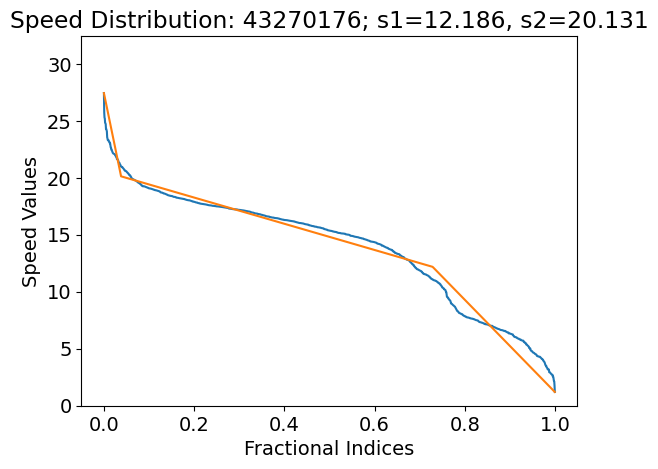

In [10]:
# files = os.listdir('/scratch/ab9738/traffic/data/Sao_Paulo/per-segment/')[:20]
files = ['43270176.csv']

for test_file in files:
    # try:
    wayid = test_file.split(".")[0]
    test_file = '/scratch/ab9738/traffic/data/Nairobi/per-segment/'+test_file

    df = pd.read_csv(test_file,error_bad_lines=False,header=None,warn_bad_lines=False)

    cols = pd.read_csv('/scratch/ab9738/traffic/data/Nairobi/movement-speeds-hourly-nairobi-2018-1.csv'\
                       ,nrows=1).columns

    df.columns = cols

    df = df.dropna()

    df = df.sort_values(by='utc_timestamp')

    tmp = df['speed_kph_mean'].to_numpy()
    series = tmp[vfunc(tmp)].astype(np.float)
    indices = np.cumsum(np.random.poisson(8, int(len(series)/8)))
    indices = indices[indices<len(series)]
    speed_sample = series[indices]

    speed_sample.sort()
    speed_sample = speed_sample[::-1]
    speed_sample = speed_sample*(1/3.6)

    ind = np.arange(len(speed_sample))
    ind = ind/len(speed_sample)
    buffer = []
    exit = []

    pwlf_func = pwlf.PiecewiseLinFit(ind, speed_sample)
    breaks = pwlf_func.fit(3, x_c=[ind[0],ind[-1]], y_c=[speed_sample[0],speed_sample[-1]])
    x_lin = np.linspace(ind[0], ind[-1], 1000)
    y_lin = pwlf_func.predict(x_lin)
    s_vals = pwlf_func.predict(breaks)
    s1, s2 = s_vals[2], s_vals[1]
    if(s1<5):
        continue

    ph1_iter = 15000-int(s1*3.6*100)
    for i in range(ph1_iter):
        s = ((15000-i)/(100.0))*(1/3.6)
        b = 4.0/(4.0+0.675*s+0.076*(s**2))
        e = s/(4.0+0.675*s+0.076*(s**2))
        buffer.append(b)
        exit.append(e)

    b1 = 4.0/(4.0+0.675*s1+0.076*(s1**2))
    b2 = 4.0/(4.0+0.675*2.5+0.076*(2.5**2))
    e1 = s/(4.0+0.675*s1+0.076*(s1**2))
    e2 = 1.0/(4.0+0.675*2.5+0.076*(2.5**2))
    slope = (exit[-1]-exit[-2])/(buffer[-1]-buffer[-2])
    A = (((e2-e1)/(b2-b1))-slope)*(1/(b2-b1))
    B = slope-(2*b1)*A
    C = e1-(B*b1)-(A*(b1**2))
    ph2_iter = int(s1*3.6*100)-900
    for i in range(ph2_iter):
        s = ((int(s1*3.6*100)-i)/(100.0))*(1/3.6)
        b = 4.0/(4.0+0.675*s+0.076*(s**2))
        e = (A*(b**2))+(B*b)+(C)
        buffer.append(b)
        exit.append(e)

    for i in range(10000):
        d = (4.0+0.675*2.5+0.076*(2.5**2))
        del_d = (d-4.0)*(i/10000.0)
        b = 4.0/(d-del_d)
        e = 1.0/(d+del_d)
        buffer.append(b)
        exit.append(e)

    buffer = np.array(buffer)
    exit = np.array(exit)

    kernel_size = 1000
    kernel = np.ones(kernel_size) / kernel_size
    exit = np.convolve(exit, kernel, mode='valid')

    fig = plt.figure(figsize=(8,5))
    plt.rcParams.update({'font.size': 14})
    plt.scatter(buffer[:len(exit)], exit, s=0.2)
    plt.title("Traffic Curve: "+wayid)
    plt.xlabel("Buffer Capacity")
    plt.ylabel("Exit Rate")
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,max(exit)+0.5)
    plt.plot(buffer[ph1_iter],exit[ph1_iter],'ro',ms=10)
    plt.plot(buffer[-10000],1.0/(4.0+0.675*2.5+0.076*(2.5**2)),'ro',ms=10)
    plt.axvline(buffer[ph1_iter], linestyle='dashed', color='green')
    plt.axvline(buffer[-10000], linestyle='dashed', color='orange')
    fig = plt.figure()
    plt.plot(ind, speed_sample)
    plt.plot(x_lin, y_lin)
    plt.title("Speed Distribution: "+wayid+'; s1='+str(round(s1,3))+', s2='+str(round(s2,3)))
    plt.xlabel("Fractional Indices")
    plt.ylabel("Speed Values")
    plt.ylim(0.0,s_vals[0]+5)
    # except:
    #     continue

In [7]:
# series = df['speed_kph_mean'].to_numpy(dtype=np.float)

# series_ma = np.ma.masked_invalid(series)
# print(series_ma.count())
# hist, bin_edges = np.histogram(series_ma, bins=100)
# cdf = np.cumsum(hist)
# bin_midpts = (bin_edges[1:] + bin_edges[:-1]) / 2
# #p, e = optimize.curve_fit(piecewise_func, bin_midpts, cdf, p0=[30, 40, 0.1, 10, 0.1, 0])
# #print(p)
# pwlf_func = pwlf.PiecewiseLinFit(bin_midpts, cdf)
# breaks = pwlf_func.fitfast(3)
# print(breaks)
# print(series_ma.min(), series_ma.max())
# print(pwlf_func.r_squared())
# xp = np.linspace(bin_edges[0], bin_edges[-1], 1000)
# #yp = piecewise_func(xp, *p)
# yp = pwlf_func.predict(xp)
# plt.plot(bin_midpts, cdf, 'o')
# plt.plot(xp, yp, c='r')

In [8]:
buffer,exit = [],[]
s1 = 7

ph1_iter = 15000-int(s1*3.6*100)
for i in range(ph1_iter):
    s = ((15000-i)/(100.0))*(1/3.6)
    b = 4.0/(4.0+0.675*s+0.076*(s**2))
    e = s/(4.0+0.675*s+0.076*(s**2))
    buffer.append(b)
    exit.append(e)

b1 = 4.0/(4.0+0.675*s1+0.076*(s1**2))
b2 = 4.0/(4.0+0.675*2.5+0.076*(2.5**2))
e1 = s/(4.0+0.675*s1+0.076*(s1**2))
e2 = 1.0/(4.0+0.675*2.5+0.076*(2.5**2))
slope = (exit[-1]-exit[-2])/(buffer[-1]-buffer[-2])
A = (((e2-e1)/(b2-b1))-slope)*(1/(b2-b1))
B = slope-(2*b1)*A
C = e1-(B*b1)-(A*(b1**2))
ph2_iter = int(s1*3.6*100)-900
for i in range(ph2_iter):
    s = ((int(s1*3.6*100)-i)/(100.0))*(1/3.6)
    b = 4.0/(4.0+0.675*s+0.076*(s**2))
    e = (A*(b**2))+(B*b)+(C)
    buffer.append(b)
    exit.append(e)

for i in range(10000):
    d = (4.0+0.675*2.5+0.076*(2.5**2))
    del_d = (d-4.0)*(i/10000.0)
    b = 4.0/(d-del_d)
    e = 1.0/(d+del_d)
    buffer.append(b)
    exit.append(e)

buffer = np.array(buffer)
exit = np.array(exit)

kernel_size = 1000
kernel = np.ones(kernel_size) / kernel_size
exit = np.convolve(exit, kernel, mode='valid')

In [109]:
buffer_ag,exit_ag = [],[]
s1 = 7

ph1_iter = 15000-int(s1*3.6*100)
for i in range(ph1_iter):
    s = ((15000-i)/(100.0))*(1/3.6)
    b = 4.0/(4.0+0.63*s+0.07*(s**2))
    e = s/(4.0+0.63*s+0.07*(s**2))
    buffer_ag.append(b)
    exit_ag.append(e)

b1 = 4.0/(4.0+0.63*s1+0.07*(s1**2))
b2 = 4.0/(4.0+0.675*2.5+0.076*(2.5**2))
e1 = s/(4.0+0.63*s1+0.07*(s1**2))
e2 = 1.0/(4.0+0.675*2.5+0.076*(2.5**2))
slope = (exit[-1]-exit[-2])/(buffer[-1]-buffer[-2])
A = (((e2-e1)/(b2-b1))-slope)*(1/(b2-b1))
B = slope-(2*b1)*A
C = e1-(B*b1)-(A*(b1**2))
for i in range(10000):
    b = b1 + (b2-b1)*(i/10000.0)
    e = (A*(b**2))+(B*b)+(C)
    buffer_ag.append(b)
    exit_ag.append(e)

for i in range(10000):
    d = (4.0+0.675*2.5+0.076*(2.5**2))
    del_d = (d-4.0)*(i/10000.0)
    b = 4.0/(d-del_d)
    e = 1.0/(d+del_d)
    buffer_ag.append(b)
    exit_ag.append(e)

buffer_ag = np.array(buffer_ag)
exit_ag = np.array(exit_ag)

kernel_size = 2000
kernel = np.ones(kernel_size) / kernel_size
exit_ag = np.concatenate([exit_ag[:ph1_iter-1],np.convolve(exit_ag[-20000:], kernel, mode='valid')],axis=0)
kernel_size = 150
kernel = np.ones(kernel_size) / kernel_size
exit_ag = np.concatenate([exit_ag[:ph1_iter-1500], np.convolve(exit_ag[ph1_iter-1500:ph1_iter+1500], kernel, mode='valid'), exit_ag[ph1_iter+1500:]],axis=0)
# exit_ag = np.convolve(exit_ag, kernel, mode='valid')

Text(0, 0.5, 'Exit Rate')

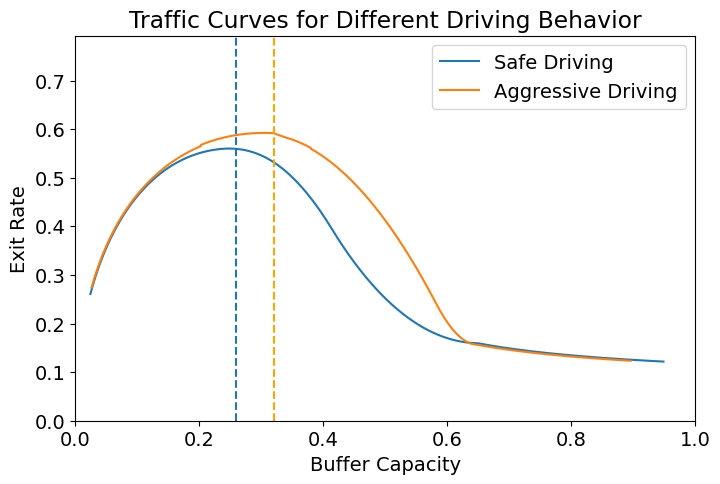

In [119]:
fig = plt.figure(figsize=(8,5))
plt.plot(buffer[:len(exit)], exit,alpha=1, label='Safe Driving')
plt.plot(buffer_ag[:len(exit_ag)], exit_ag,alpha=1, label='Aggressive Driving')
plt.xlim(0.0,1.0)
plt.ylim(0.0,max(exit_ag)+0.2)
plt.axvline(0.26, linestyle='dashed')
plt.axvline(0.32, linestyle='dashed',color='orange')
plt.title('Traffic Curves for Different Driving Behavior')
plt.legend()
plt.xlabel('Buffer Capacity')
plt.ylabel('Exit Rate')